<font color="orange">Local volatility under rough volatility</font>


The rough Bergomi model is defined as

\begin{align*}
    dS_t &= S_t \sqrt{\xi_t^t} \, dW_t^S, \\
    \xi_t^u &= \xi_0^u \exp \left\{
        \eta Y_t^u - \frac{\eta^2}{2} (u^{2H} - (u-t)^{2H})
    \right\}
\end{align*}

where 

$$
    Y_t^u = \sqrt{2H} \int_0^t (u-s)^{H-1/2} \, dW_s^V.
$$

The correlation between the Brownian motions $W^S$ and $W^V$ is given by $\rho$.

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from rbergomi import RoughBergomi
import numpy as np
from scipy import integrate
import time
import seaborn as sns

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)

In [5]:
# Set model parameters and create three instances of the rough Bergomi model with
# H = 0.1, 0.3, and 0.5

list_H = [0.1, 0.3, 0.5]

params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "eta": 1.0,
    "rho": -0.7,
}

rbergomi_models = {f"H={H}": RoughBergomi(**params, H=H) for H in list_H}

In [6]:
COLORS = {0.1: "blue", 0.3: "green", 0.5: "red"}
MARKERS = {0.1: ".", 0.3: "+", 0.5: "x"}
SEED = 1234
n_disc = 300
n_mc = 3 * 10**5
n_loop = 1

We compute the: 

- ATM local volatility skew $\partial_k \sigma_{loc}(T,k)|_{k=0}$
- ATM implied volatility skew $\partial_k \sigma_{BS}(T,k)|_{k=0}$ 

and compare them.

In [ ]:
# # option to simulate one path and then split.
# # n_disc_split = number of time steps for each split
# # this is faster than the alternative of resimulating each time but less precise.

# tab_t = np.linspace(0.0, 0.5, n_disc + 1)
# dt = tab_t[1] - tab_t[0]
# n_disc_split = 100

# atm_impvols = {}
# atm_impvol_skews = {}
# atm_lvs = {}
# atm_lv_skews = {}

# for H in list_H:
#     t0 = time.time()
#     print("H =", H)
#     res = rbergomi_models[f"H={H}"].atm_implied_vol_local_vol_skew(
#         tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=seed, n_disc_split=n_disc_split
#     )
#     atm_impvols[f"H={H}"], atm_impvol_skews[f"H={H}"] = res[1]
#     atm_lvs[f"H={H}"], atm_lv_skews[f"H={H}"] = res[2]
#     print(f"time taken: {(time.time() - t0):.2f} seconds\n")

# list_maturity = [t[-1] for t in np.split(tab_t[1:], n_disc // n_disc_split)]

In [7]:
# For each H and maturity in list_maturity, we compute the ATM implied vol, local vol,
# and their skews.

list_maturity = [0.1, 0.2, 0.3, 0.4, 0.5]

atm_impvols = {}
atm_impvol_skews = {}
atm_lvs = {}
atm_lv_skews = {}

for H in list_H:
    t0 = time.time()
    print("H =", H)
    res_impvol = np.zeros((2, len(list_maturity)))
    res_lv = np.zeros((2, len(list_maturity)))
    for i, maturity in enumerate(list_maturity):
        print(f"maturity = {maturity}")
        tab_t = np.linspace(0.0, maturity, n_disc + 1)
        tmp = rbergomi_models[f"H={H}"].atm_implied_vol_local_vol_skew(
            tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=SEED, n_disc_split=n_disc
        )
        res_impvol[:, i] = np.asarray(tmp[1]).flatten()
        res_lv[:, i] = np.asarray(tmp[2]).flatten()
    print("\n")
    atm_impvols[f"H={H}"], atm_impvol_skews[f"H={H}"] = res_impvol
    atm_lvs[f"H={H}"], atm_lv_skews[f"H={H}"] = res_lv
    print(f"time taken: {(time.time() - t0):.2f} seconds\n")

H = 0.1
maturity = 0.1
maturity = 0.2
maturity = 0.3
maturity = 0.4
maturity = 0.5


time taken: 93.92 seconds

H = 0.3
maturity = 0.1
maturity = 0.2
maturity = 0.3
maturity = 0.4
maturity = 0.5


time taken: 83.82 seconds

H = 0.5
maturity = 0.1
maturity = 0.2
maturity = 0.3
maturity = 0.4
maturity = 0.5


time taken: 63.38 seconds



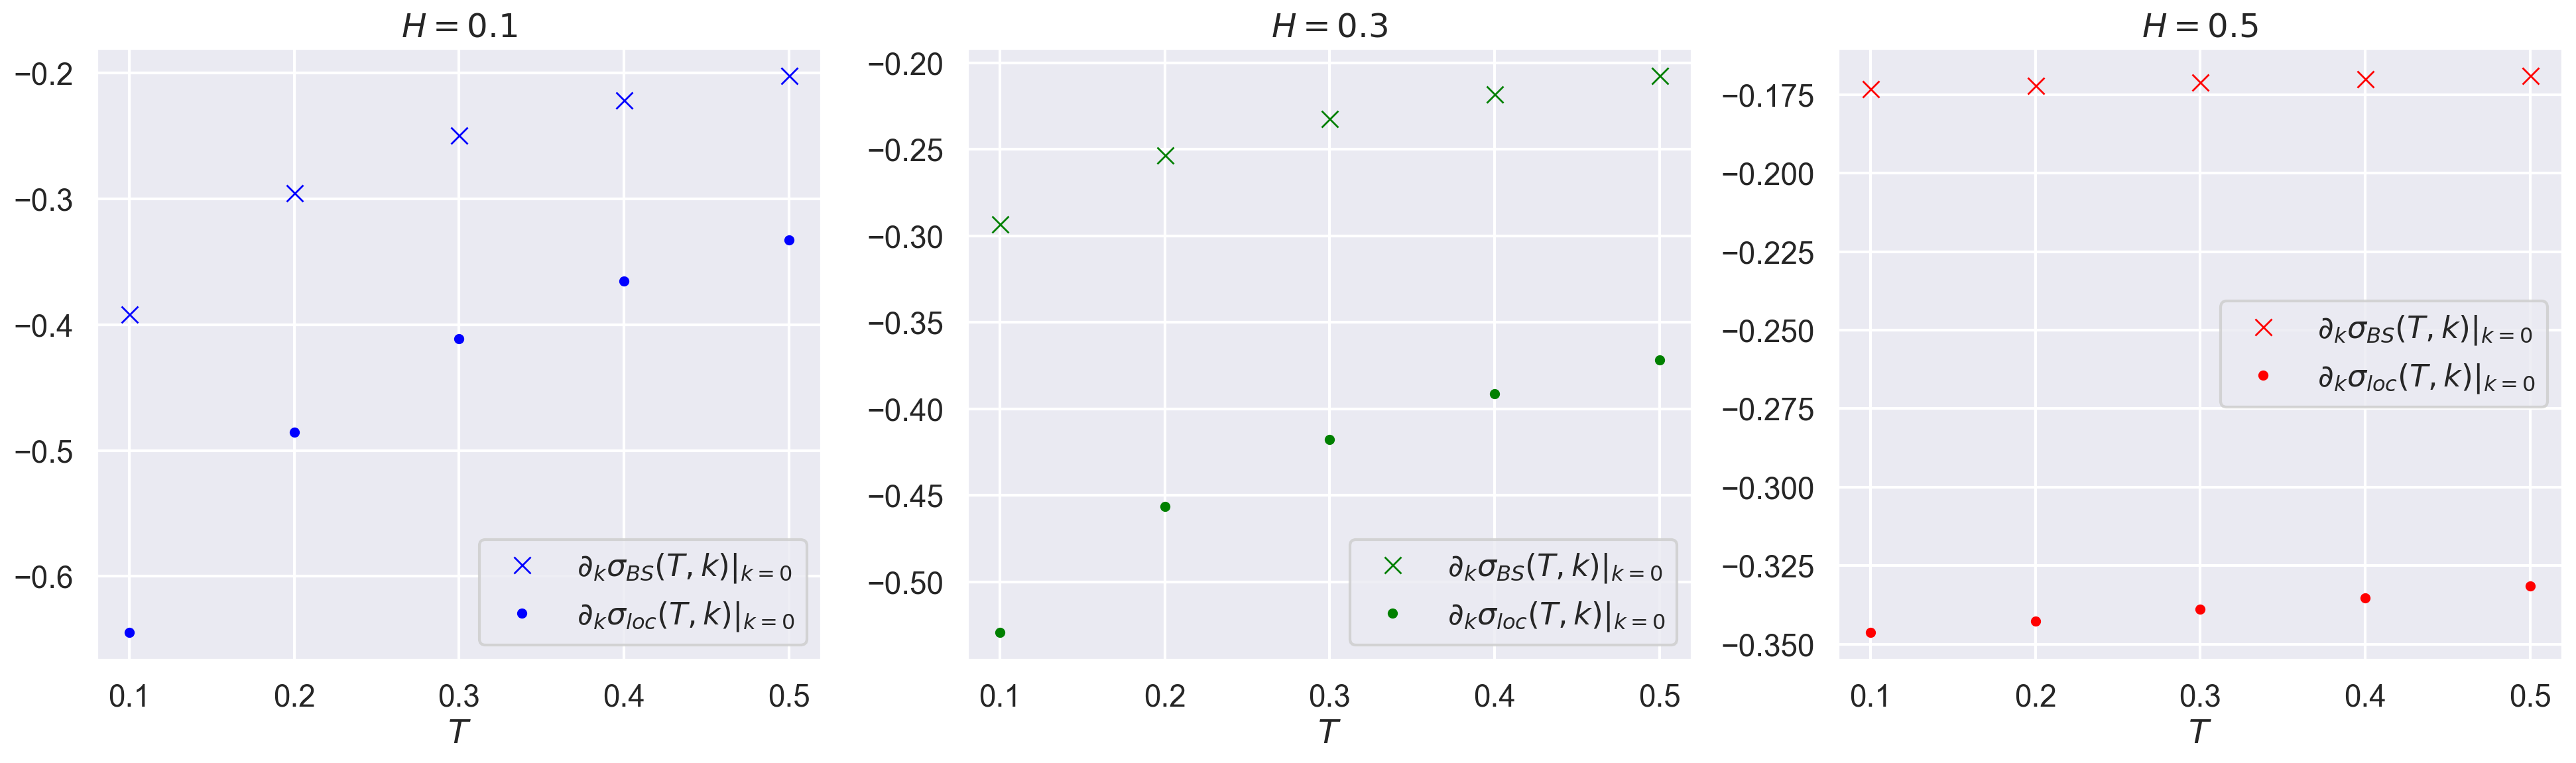

In [8]:
plt.close()
fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 6))
for i in range(len(list_H)):
    H = list_H[i]
    ax[i].plot(
        list_maturity,
        atm_impvol_skews[f"H={H}"],
        "x",
        label="$\\partial_k \\sigma_{BS}(T,k)|_{k=0}$",
        color=COLORS[H],
    )
    ax[i].plot(
        list_maturity,
        atm_lv_skews[f"H={H}"],
        ".",
        label="$\\partial_k \\sigma_{loc}(T,k)|_{k=0}$",
        color=COLORS[H],
    )
    ax[i].set_title(f"$H={H}$")
    ax[i].set_xlabel("$T$")
    ax[i].legend()
plt.show()

We want to check the "$H+3/2$" rule, that is

$$
    \frac{\partial_k \sigma_{BS}(T,k)|_{k=0}}{\partial_k \sigma_{loc}(T,k)|_{k=0}}
    \underset{T\to0}{\to} \frac{1}{H+3/2}
$$

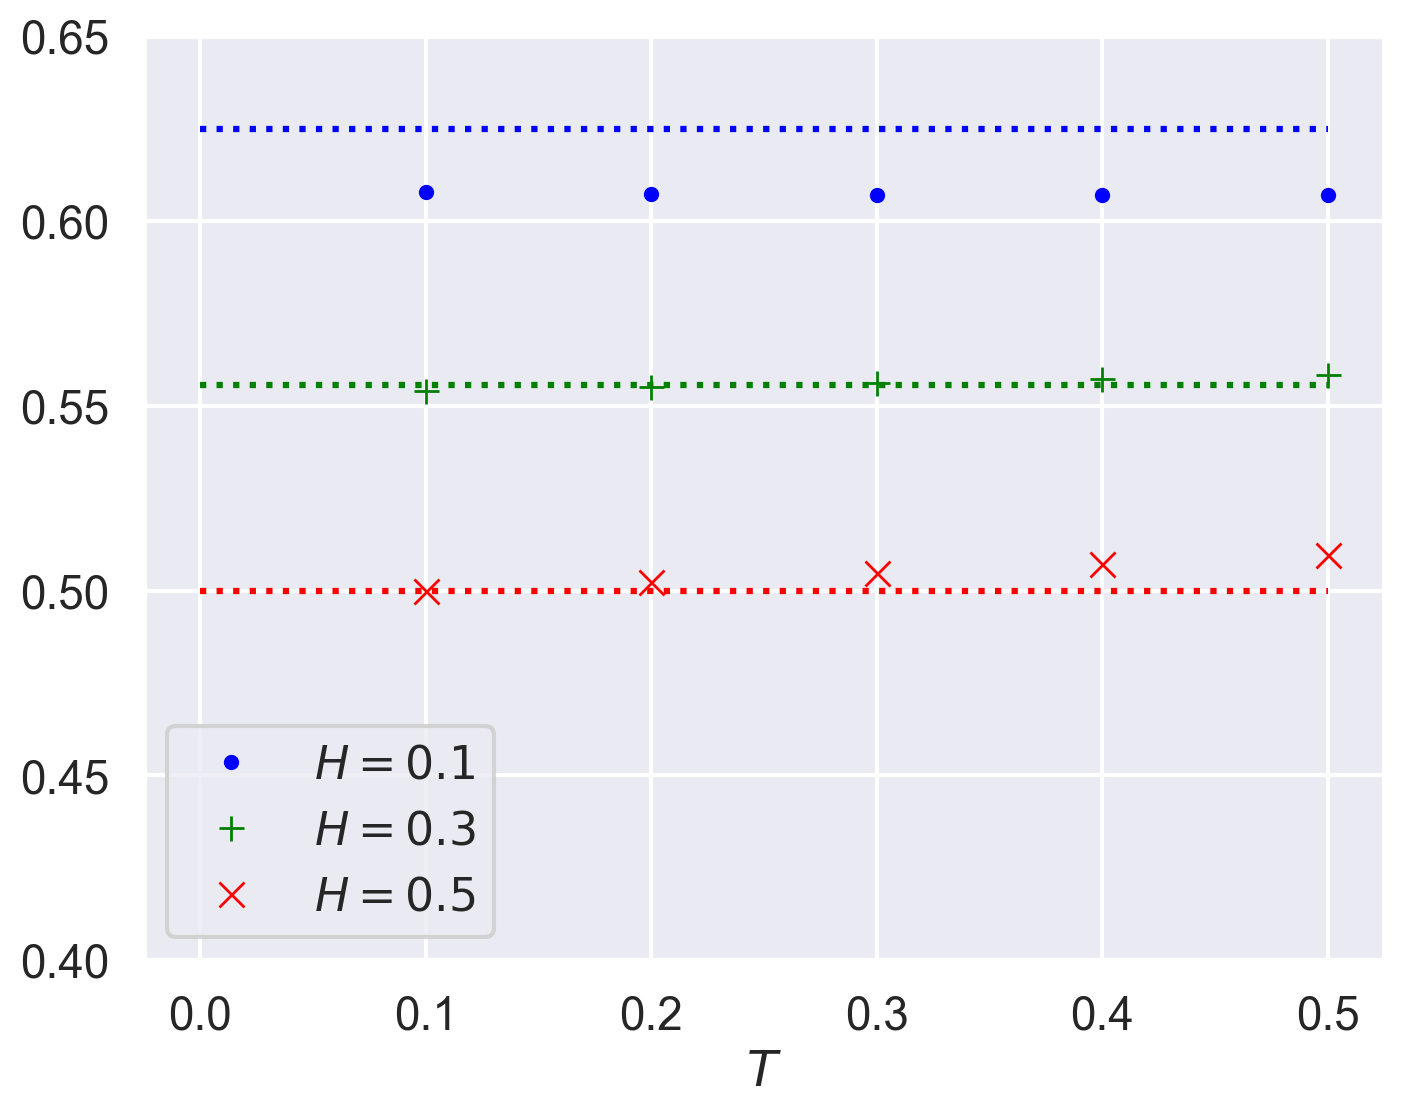

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
for H in list_H:
    ax.plot(
        list_maturity,
        atm_impvol_skews[f"H={H}"] / atm_lv_skews[f"H={H}"],
        MARKERS[H],
        label=f"$H={H}$",
        color=COLORS[H],
    )
    ax.plot(tab_t, 1.0 / (H + 1.5) * np.ones_like(tab_t), ":", color=COLORS[H])
ax.set_xlabel("$T$")
ax.legend(ncol=1)
ax.set_ylim(0.40, 0.65)
plt.show()

We compare the implied volatility $\sigma_{BS}(T,k)$ and the harmonic mean
$H(T,k)$ of the local volatility $\sigma_{loc}(T,k)$ defined as 

$$
    H(T,k) = \left(\frac{1}{k}\int_0^k \frac{dy}{\sigma_{loc}(T,y)}\right)^{-1}
$$

In [11]:
H = 0.3
T = 0.45

tab_t = np.linspace(0.0, T, n_disc + 1)
paths = rbergomi_models[f"H={H}"].simulate(
    tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=SEED, conditioning=True
)


def func_locvol(y):
    return rbergomi_models[f"H={H}"].local_vol_from_paths(
        k=y,
        v_t=paths["v"][-1, :],
        int_v_dt=paths["int_v_dt"],
        int_sqrt_v_dw=paths["int_sqrt_v_dw"],
    )

In [12]:
def harmonic_mean_loc_vol(k):
    if k == 0.0:
        return func_locvol(0.0)[0]
    return 1.0 / (integrate.quad(lambda y: 1.0 / func_locvol(y)[0], 0, k)[0] / k)

In [13]:
tab_k = np.linspace(-0.2, 0.05, 11)
harmo_means = np.array([harmonic_mean_loc_vol(k) for k in tab_k])

In [14]:
impvol = rbergomi_models[f"H={H}"].implied_vol_from_paths(
    k=tab_k,
    T=T,
    int_v_dt=paths["int_v_dt"],
    int_sqrt_v_dw=paths["int_sqrt_v_dw"],
    conditioning=True,
)

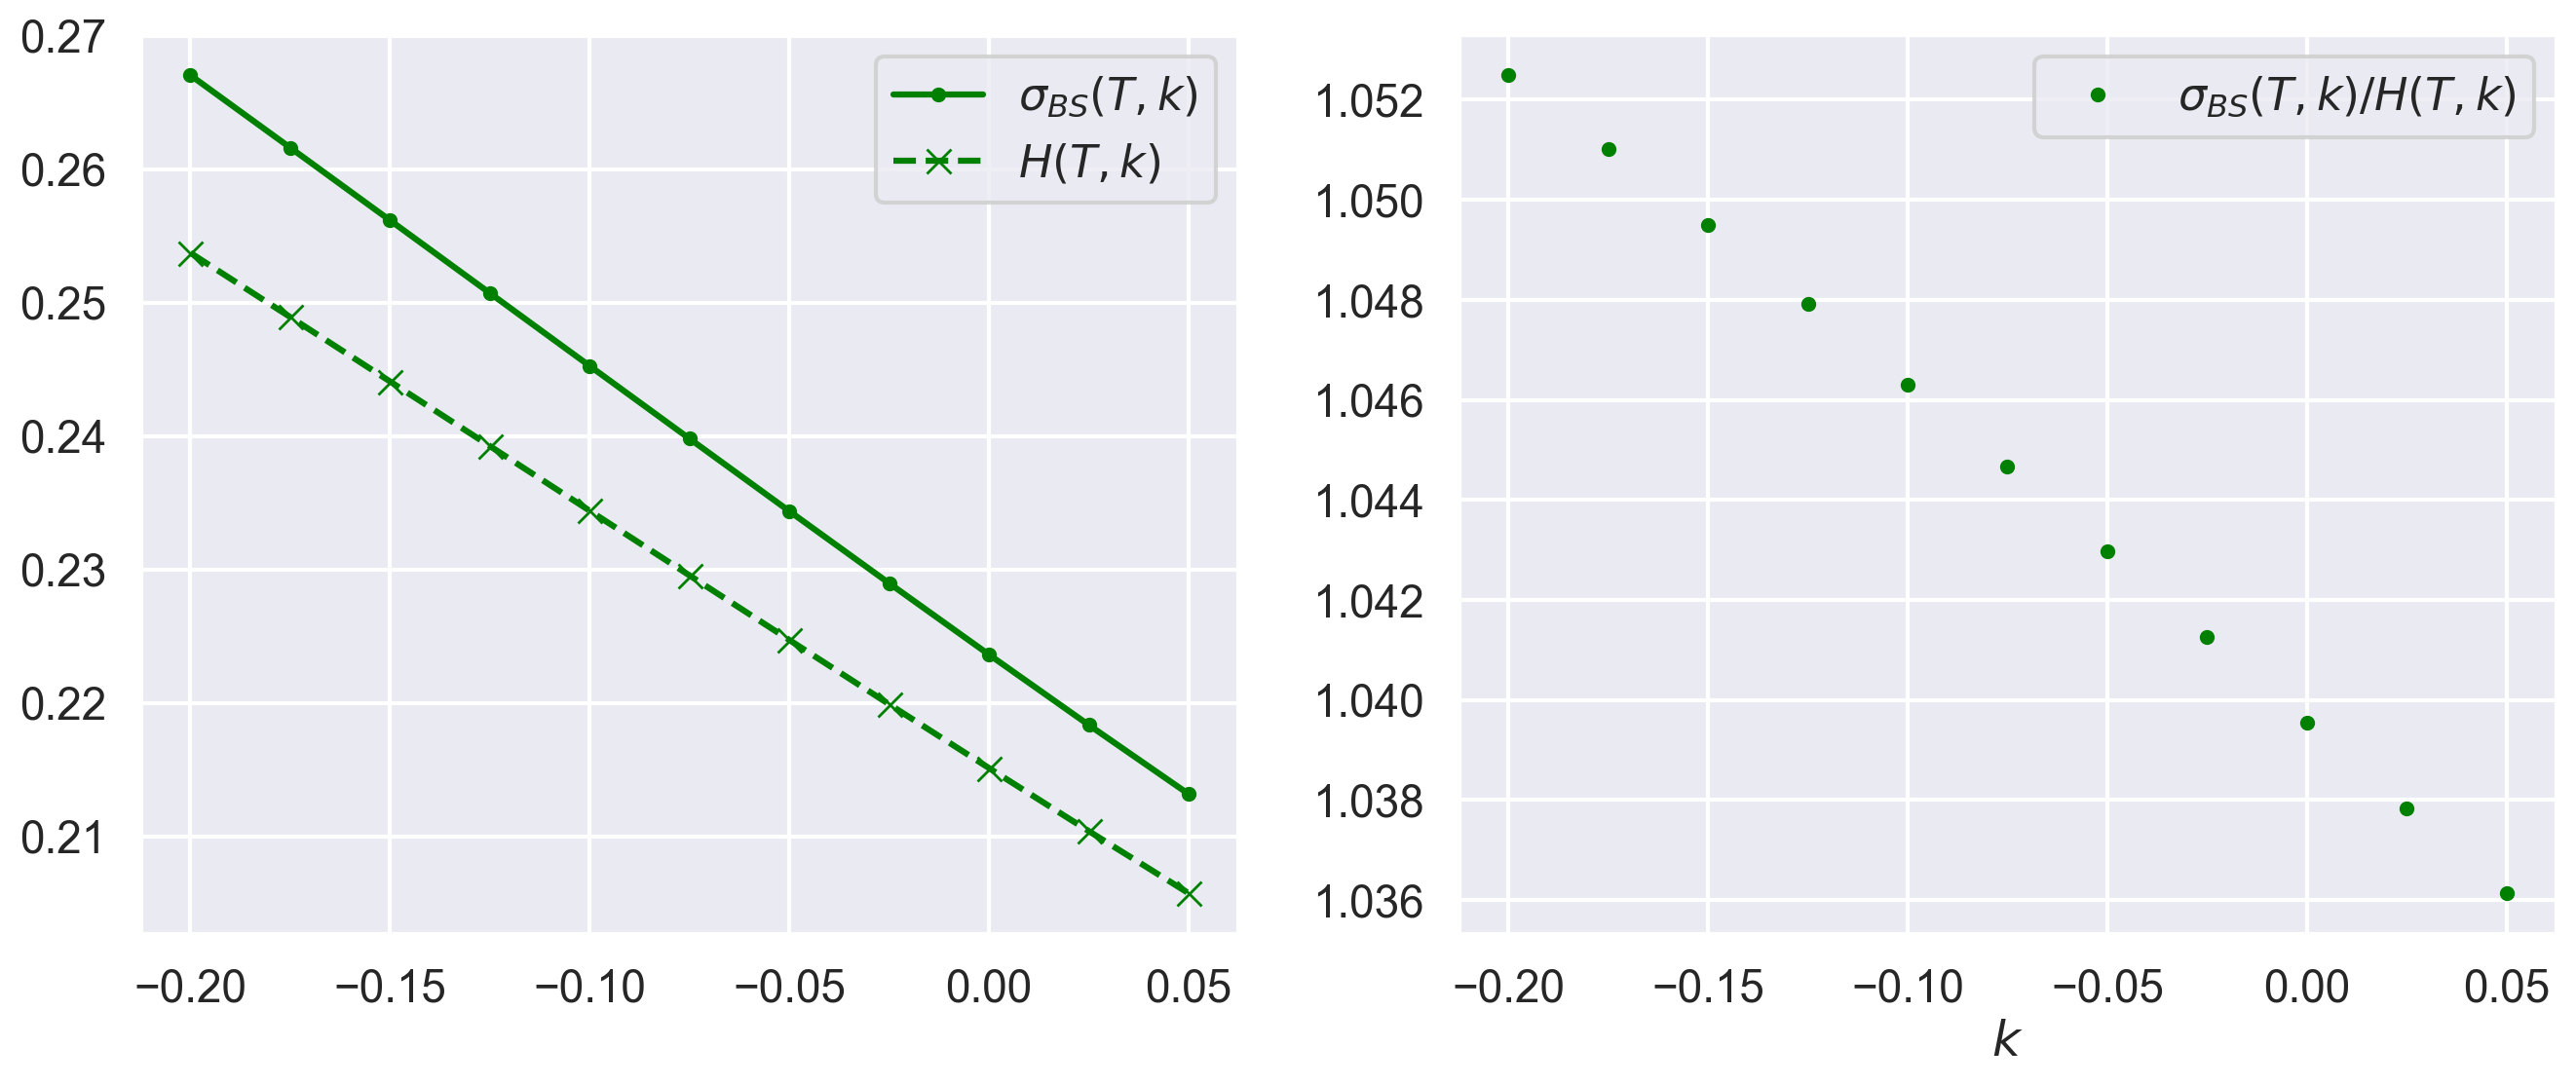

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(tab_k, impvol, ".-", label=r"$\sigma_{BS}(T,k)$", color=COLORS[H])
ax[0].plot(tab_k, harmo_means, "x--", label="$H(T,k)$", color=COLORS[H])
ax[0].legend()
ax[1].plot(
    tab_k,
    impvol / harmo_means,
    ".",
    label=r"$\sigma_{BS}(T,k) / H(T,k)$",
    color=COLORS[H],
)
ax[1].set_xlabel("$k$")
ax[1].legend()
plt.show()

Comparison of $\sigma_{loc}(T,y \, T^{1/2-H})$ and $\sigma(\widehat{h_1^y})$ for 
$T \in \{0.05, 0.2, 0.35, 0.5\}$.

The rate function minimizing path $\widehat{h}_1^y$ is evaluated using the Ritz 
projection method with $N=8$ Fourier basis functions. We refer to section 
4.2. for details.

In [22]:
# Set a value for H
H = 0.3
print("H =", H, "\n")

n_mc = 1 * 10**5
n_disc = 200
n_loop = 1
y = np.linspace(-0.5, 0.5, 11)
list_T = [0.05, 0.2, 0.35, 0.5]
lv_y = np.zeros((len(list_T), y.shape[0]))

for i, T in enumerate(list_T):
    print("T =", T)
    lv_y[i, :] = rbergomi_models[f"H={H}"].local_vol(
        k=y * T ** (0.5 - H), T=T, n_mc=n_mc, n_disc=n_disc, n_loop=n_loop, seed=SEED
    )

H = 0.3 

T = 0.05
T = 0.2
T = 0.35
T = 0.5


In [23]:
n_trunc = 8
sig_h = rbergomi_models[f"H={H}"].sigma_path_rate_function(y=y, n_trunc=n_trunc)

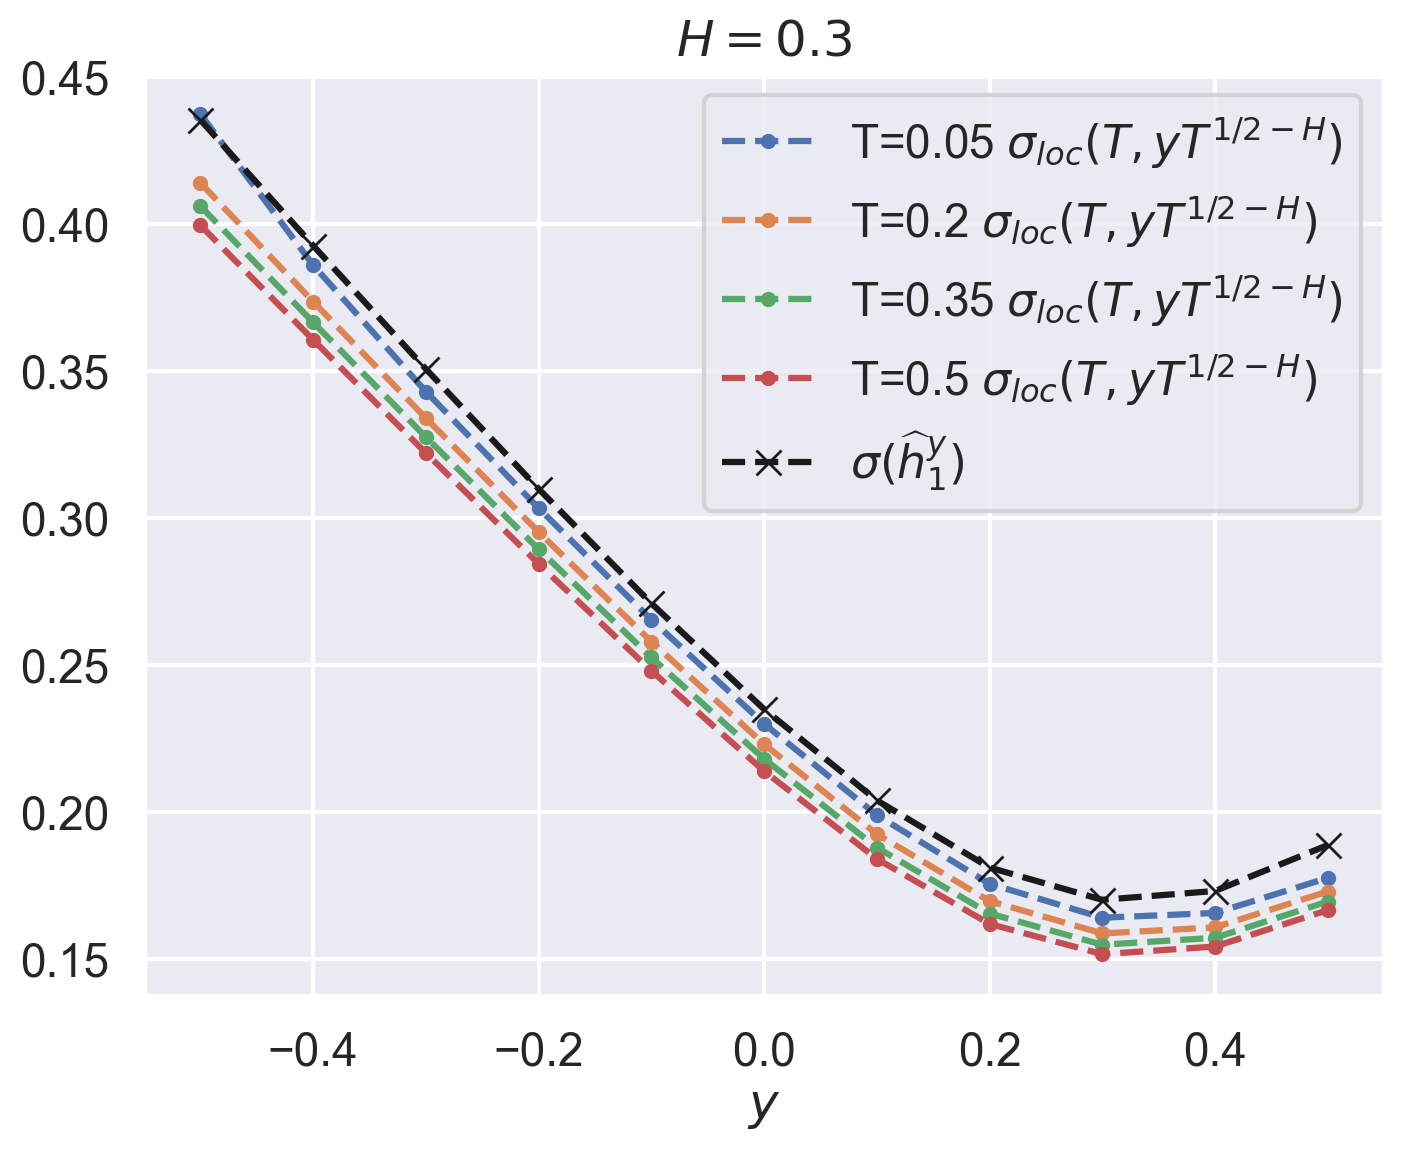

In [24]:
fig, ax = plt.subplots()
for i, T in enumerate(list_T):
    ax.plot(y, lv_y[i, :], ".--", label=f"T={T} " + r"$\sigma_{loc}(T,yT^{1/2-H})$")
ax.plot(y, sig_h, "x--k", label=r"$\sigma(\widehat{h}_1^y)$")
ax.set_xlabel("$y$")
ax.set_title(f"$H={H}$")
ax.legend()
plt.show()